In [26]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns

#reading Dataset
# retail = pd.read_csv("Online Retail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)
# parse date
# retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d/%m/%y %H:%M")

### Grouping customers in terms of recency, frequency and monetary

In [2]:
excel_data = pd.read_excel("Online Retail.xlsx")

In [3]:
excel_data.to_csv("Online_Retail.csv", sep = ',', index = None)

In [4]:
input_data = pd.read_csv("Online_Retail.csv")

In [5]:
input_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
order_wise = input_data.dropna()

In [7]:
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])

In [8]:
order_wise = pd.concat([order_wise, amount], axis = 1, ignore_index = False)

In [9]:
order_wise.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [10]:
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()

In [11]:
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Computing the frequency

In [12]:
frequency = order_wise[['CustomerID', 'InvoiceNo']]
k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]

In [13]:
master = monetary.merge(k, on = "CustomerID", how = "inner")

In [14]:
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


### Composing the recency

In [20]:
recency  = order_wise[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)
maximum = pd.to_datetime(maximum) + pd.DateOffset(days=1)
recency['diff'] = pd.to_datetime(maximum) - pd.to_datetime(recency.InvoiceDate)

#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]

/home/chandan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [21]:
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


In [22]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")

In [23]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


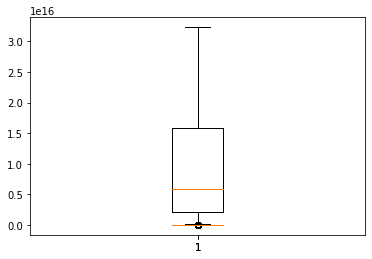

In [28]:
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]


In [29]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00


In [30]:
RFM_normal = RFM.drop("CustomerID", axis =1)

In [37]:
RFM_normal.Recency = RFM_normal.Recency.dt.days

In [38]:
RFM_normal.head()

,Frequency,Amount,Recency
0,2,0.00,326
2,31,1797.24,75
3,73,1757.55,19
4,17,334.40,310
5,95,1545.41,36


In [39]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
standard_scaler.fit_transform(RFM_normal)

/home/chandan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/chandan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-1.15244639, -1.19318304,  2.04185708],
       [-0.21699078,  2.30235709, -0.33848271],
       [ 1.13780701,  2.22516207, -0.86955453],
       ...,
       [-0.99116094, -1.03599227,  0.66676039],
       [-0.7976184 , -0.84970505, -0.97387221],
       [ 1.04103574,  2.38023285, -0.64195232]])

### find the optimal k

In [40]:
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters= num_clusters, max_iter= 50)
    model_clus.fit(RFM_normal)
    ssd.append(model_clus.inertia_)

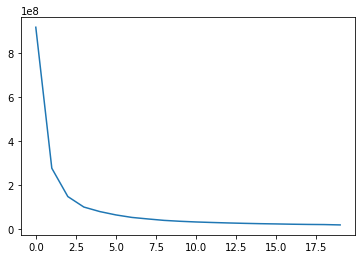

In [42]:
plt.plot(ssd)

In [44]:
kmeans5 = KMeans(n_clusters= 5, max_iter= 50)
kmeans5.fit(RFM_normal)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
RFM.index = pd.RangeIndex(len(RFM.index))
km = pd.concat([RFM, pd.Series(kmeans5.labels_)], axis =1)

In [48]:
km.columns = ["CustomerID", "Frequency", "Amount", "Recency", "ClusterID"]

In [49]:
km.head()

,CustomerID,Frequency,Amount,Recency,ClusterID
0,12346.0,2,0.00,326 days 02:33:00,4
1,12348.0,31,1797.24,75 days 23:37:00,2
2,12349.0,73,1757.55,19 days 02:59:00,2
3,12350.0,17,334.40,310 days 20:49:00,1
4,12352.0,95,1545.41,36 days 22:13:00,2


In [51]:
km.Recency = km.Recency.dt.days

In [56]:
km_amount = km.groupby("ClusterID").Amount.mean()
km_frequency = km.groupby("ClusterID").Frequency.mean()
km_recency = km.groupby("ClusterID").Recency.mean()

In [59]:
km_amount

ClusterID
0    1194.914000
1     397.271379
2    1824.008521
3     729.804009
4     155.492014
Name: Amount, dtype: float64

In [64]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_amount, km_frequency, km_recency], axis =1)

In [66]:
df.columns = ["ClusterID", "Amount", "Frequency", "Recency"]

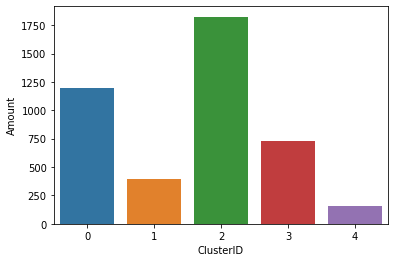

In [67]:
sns.barplot(x = df.ClusterID, y = df.Amount)

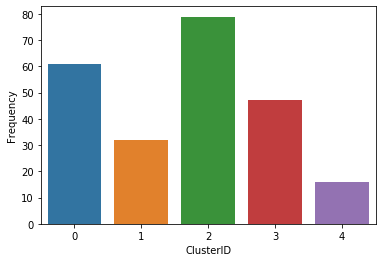

In [68]:
sns.barplot(x = df.ClusterID, y = df.Frequency)

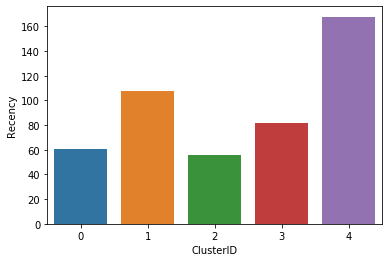

In [69]:
sns.barplot(x = df.ClusterID, y = df.Recency)